# Parsing San Jose PD's firearm search reports

This example uses `pdfplumber`'s visual debugging and text-extraction features to parse a fixed-width table embedded in a PDF. Thanks to [Ron Campbell](https://twitter.com/campbellronaldw) for the sample PDF.

In [1]:
import pdfplumber
import re
print(pdfplumber.__version__)

0.6.0


## Load the PDF

In [2]:
pdf = pdfplumber.open("../pdfs/san-jose-pd-firearm-sample.pdf")

## Examine the first page

In [3]:
p0 = pdf.pages[0]

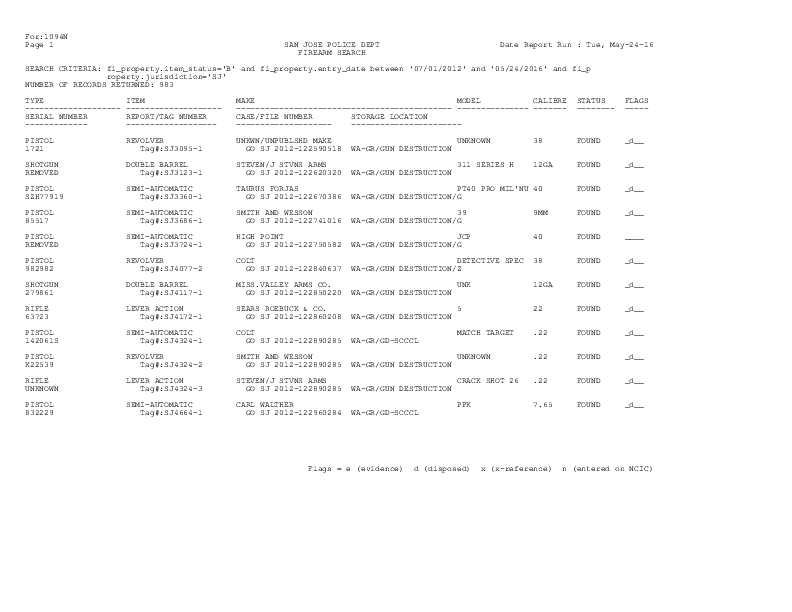

In [4]:
im = p0.to_image()
im

## See where the characters are on the page

Below, we draw rectangles around each of the `char` objects that `pdfplumber` detected. By doing so, we can see that every line of the main part of the report is the same width, and that there are space (`" "`) characters padding out each field. That means we can parse those lines a lot like we'd parse a standard fixed-width data file.

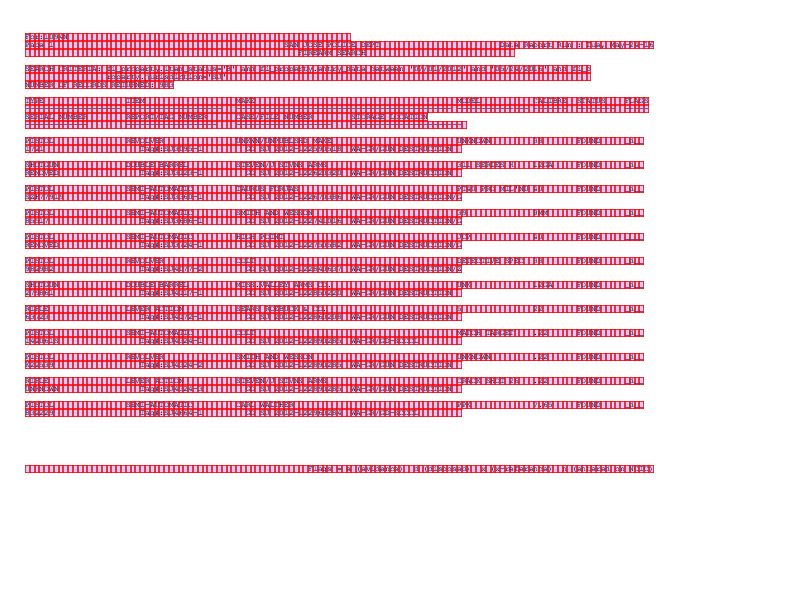

In [5]:
im.reset().draw_rects(p0.chars)

## Extract the text from the PDF

Using the `Page.extract_text(...)` method, we grab every character on the page, line by line:

In [6]:
text = p0.extract_text()
print(text)

For:1094N                                                           
Page 1                                                SAN JOSE POLICE DEPT                         Date Report Run : Tue, May-24-16
                                                         FIREARM SEARCH                               
SEARCH CRITERIA: fi_property.item_status='B' and fi_property.entry_date between '07/01/2012' and '05/24/2016' and fi_p
                 roperty.jurisdiction='SJ'                                                                            
NUMBER OF RECORDS RETURNED: 983
TYPE                 ITEM                   MAKE                                          MODEL           CALIBRE  STATUS    FLAGS
-------------------- --------------------   --------------------------------------------- --------------- -------  --------  -----
SERIAL NUMBER        REPORT/TAG NUMBER      CASE/FILE NUMBER        STORAGE LOCATION
-------------        -------------------    --------------------    -----------

## Stripping away the header and footer

In this step, we use a regular expression to focus on the core part of the page — the table.

In [7]:
core_pat = re.compile(r"LOCATION[\-\s]+(.*)\n\s+Flags = e", re.DOTALL)

In [8]:
core = re.search(core_pat, text).group(1)

In [9]:
print(core)

PISTOL               REVOLVER               UNKWN/UNPUBLSHD MAKE                          UNKNOWN         38       FOUND     _d__
1721                    Tag#:SJ3095-1         GO SJ 2012-122590518  WA-GR/GUN DESTRUCTION  
SHOTGUN              DOUBLE BARREL          STEVEN/J STVNS ARMS                           311 SERIES H    12GA     FOUND     _d__
REMOVED                 Tag#:SJ3123-1         GO SJ 2012-122620320  WA-GR/GUN DESTRUCTION  
PISTOL               SEMI-AUTOMATIC         TAURUS FORJAS                                 PT40 PRO MIL'NU 40       FOUND     _d__
SZH77919                Tag#:SJ3360-1         GO SJ 2012-122670386  WA-GR/GUN DESTRUCTION/G
PISTOL               SEMI-AUTOMATIC         SMITH AND WESSON                              39              9MM      FOUND     _d__
85517                   Tag#:SJ3686-1         GO SJ 2012-122741016  WA-GR/GUN DESTRUCTION/G
PISTOL               SEMI-AUTOMATIC         HIGH POINT                                    JCP             40    

## Parse each group of two lines

In the report, each firearm takes up two lines. The code below splits the core table into two-line groups, and then parses out the fields, based on the number of characters in each field:

In [10]:
lines = core.split("\n")
line_groups = list(zip(lines[::2], lines[1::2]))
print(line_groups[0])

('PISTOL               REVOLVER               UNKWN/UNPUBLSHD MAKE                          UNKNOWN         38       FOUND     _d__', '1721                    Tag#:SJ3095-1         GO SJ 2012-122590518  WA-GR/GUN DESTRUCTION  ')


In [11]:
def parse_row(first_line, second_line):
    return {
        "type": first_line[:20].strip(),
        "item": first_line[21:41].strip(),
        "make": first_line[44:89].strip(),
        "model": first_line[90:105].strip(),
        "calibre": first_line[106:111].strip(),
        "status": first_line[112:120].strip(),
        "flags": first_line[124:129].strip(),
        "serial_number": second_line[0:13].strip(),
        "report_tag_number": second_line[21:41].strip(),
        "case_file_number": second_line[44:64].strip(),
        "storage_location": second_line[68:91].strip(),
    }

In [12]:
parsed = [ parse_row(first_line, second_line) 
    for first_line, second_line in line_groups ]

## Result

Below, you can see the parsed data for the first two firearms in the report:

In [13]:
parsed[:2]

[{'type': 'PISTOL',
  'item': 'REVOLVER',
  'make': 'UNKWN/UNPUBLSHD MAKE',
  'model': 'UNKNOWN',
  'calibre': '38',
  'status': 'FOUND',
  'flags': '_d__',
  'serial_number': '1721',
  'report_tag_number': 'Tag#:SJ3095-1',
  'case_file_number': 'GO SJ 2012-1225905',
  'storage_location': 'WA-GR/GUN DESTRUCTION'},
 {'type': 'SHOTGUN',
  'item': 'DOUBLE BARREL',
  'make': 'STEVEN/J STVNS ARMS',
  'model': '311 SERIES H',
  'calibre': '12GA',
  'status': 'FOUND',
  'flags': '_d__',
  'serial_number': 'REMOVED',
  'report_tag_number': 'Tag#:SJ3123-1',
  'case_file_number': 'GO SJ 2012-1226203',
  'storage_location': 'WA-GR/GUN DESTRUCTION'}]

## Preview via `pandas.DataFrame`

To make it a little easier to read, here's the full table, parsed and represented as a `pandas.DataFrame` (for ease of viewing):

In [14]:
import pandas as pd
columns = list(parsed[0].keys())
pd.DataFrame(parsed)[columns]

,type,item,make,model,calibre,status,flags,serial_number,report_tag_number,case_file_number,storage_location
0,PISTOL,REVOLVER,UNKWN/UNPUBLSHD MAKE,UNKNOWN,38,FOUND,_d__,1721,Tag#:SJ3095-1,GO SJ 2012-1225905,WA-GR/GUN DESTRUCTION
1,SHOTGUN,DOUBLE BARREL,STEVEN/J STVNS ARMS,311 SERIES H,12GA,FOUND,_d__,REMOVED,Tag#:SJ3123-1,GO SJ 2012-1226203,WA-GR/GUN DESTRUCTION
2,PISTOL,SEMI-AUTOMATIC,TAURUS FORJAS,PT40 PRO MIL'NU,40,FOUND,_d__,SZH77919,Tag#:SJ3360-1,GO SJ 2012-1226703,WA-GR/GUN DESTRUCTION/G
3,PISTOL,SEMI-AUTOMATIC,SMITH AND WESSON,39,9MM,FOUND,_d__,85517,Tag#:SJ3686-1,GO SJ 2012-1227410,WA-GR/GUN DESTRUCTION/G
4,PISTOL,SEMI-AUTOMATIC,HIGH POINT,JCP,40,FOUND,____,REMOVED,Tag#:SJ3724-1,GO SJ 2012-1227505,WA-GR/GUN DESTRUCTION/G
5,PISTOL,REVOLVER,COLT,DETECTIVE SPEC,38,FOUND,_d__,982982,Tag#:SJ4077-2,GO SJ 2012-1228406,WA-GR/GUN DESTRUCTION/Z
6,SHOTGUN,DOUBLE BARREL,MISS.VALLEY ARMS CO.,UNK,12GA,FOUND,_d__,279861,Tag#:SJ4117-1,GO SJ 2012-1228502,WA-GR/GUN DESTRUCTION
7,RIFLE,LEVER ACTION,SEARS ROEBUCK & CO.,5,22,FOUND,_d__,63723,Tag#:SJ4172-1,GO SJ 2012-1228602,WA-GR/GUN DESTRUCTION
8,PISTOL,SEMI-AUTOMATIC,COLT,MATCH TARGET,.22,FOUND,_d__,142061S,Tag#:SJ4324-1,GO SJ 2012-1228902,WA-GR/GD-SCCCL
9,PISTOL,REVOLVER,SMITH AND WESSON,UNKNOWN,.22,FOUND,_d__,K22539,Tag#:SJ4324-2,GO SJ 2012-1228902,WA-GR/GUN DESTRUCTION


---

---

---